In [ ]:
# @title Import Requirements
from IPython.display import clear_output
import os
import io
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from tqdm.notebook import tqdm

import torch

# Local Import
from modeling_bert import BertModel

from transformers import (
    BertConfig,
    BertTokenizer,
)

SELECTED_GPU = 0
if torch.cuda.is_available():    
  # Tell PyTorch to use the GPU.    
  device = torch.device("cuda:{}".format(SELECTED_GPU))
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(SELECTED_GPU))


There are 2 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [ ]:
fdir = '/home/username/NLP/Data/SentEval/data/probing/'    
BATCH_SIZE = 64
MAX_LENGTH = 48
NUM_HEAD = 12

TASK_NAME = 'bigram_shift.txt'

CLASSIFIER_MODEL_FPATH = '/home/username/NLP/Models/SentEvalAnalysis/BERT_AVG_Classifiers/'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
#@title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '~/NLP/Data/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(torch.nn.Module):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask):
      with torch.no_grad():
        _, _, middle_hidden_states, middle_attentions, middle_norms = self.bert(input_ids, attention_mask,
                                                                            output_hidden_states=True,
                                                                            output_attentions=True,
                                                                            output_norms=True)

        hidden_states = []
        attentions = []
        fx_norms = []
        afx_norms = []
        summed_afx_norms = []
        for i in range(12):
            hidden_states.append(middle_hidden_states[i+1])
            attentions.append(middle_attentions[i])
            fx_norms.append(middle_norms[i][0])
            afx_norms.append(middle_norms[i][1])
            summed_afx_norms.append(middle_norms[i][2])
        return (torch.stack(hidden_states),
                torch.stack(attentions), 
                torch.stack(fx_norms), torch.stack(afx_norms), torch.stack(summed_afx_norms))
        # output form:
        # (12-layer-representations, 12-layer-attentions,
        #  12-layer-fx_norms, 12-layer-afx_norms, 12-layer-summed_afx_norms)


In [ ]:
# @title Load BERT Model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = BertModel.from_pretrained("bert-base-uncased").to(device)
loaded_model.eval()

probing_model = BertReprProbing(loaded_model)
clear_output()
print("Done!")

Done!


In [ ]:
def index_to_id(example, target_pos):
  pos = 1 # 1 for counting CLS
  for index in range(target_pos):
    pos += len(tokenizer.encode(example[index], add_special_tokens=False))
  return list(range(pos, pos+len(tokenizer.encode(example[target_pos], add_special_tokens=False))))

In [ ]:
PUNC = [".", ",", "!", "@", "#", "$", "%", "&", "*", "(", ")", "'", "\"", ";", ":", "?", "<", ">", "{", "}", "[", "]", "\\", "/", "?"]

In [ ]:
# @title Probe Feature Extraction
np.random.seed(15)

probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

del task_data['train']
del task_data['dev']

# Keep Only Original Examples

inverted_data = []
original_data = []
first_position = []
second_position = []

for data in zip(task_data['test']['X'], task_data['test']['y']):
  example, label = data
  if label == 0:
    continue

  original_data.append(example)  
  chunked = example.split()

  while(True):
    bi_pos = np.random.randint(low=1, high=len(chunked)-1)
    if chunked[bi_pos] not in PUNC and chunked[bi_pos+1] not in PUNC:
      break
    
  
  first_position.append(index_to_id(chunked, bi_pos))
  second_position.append(index_to_id(chunked, bi_pos+1))

  chunked[bi_pos], chunked[bi_pos+1] = chunked[bi_pos+1], chunked[bi_pos]
  chunked = ' '.join(chunked)

  inverted_data.append(chunked)


no_examples = len(original_data)
steps = int(np.ceil(no_examples / BATCH_SIZE))

attentions = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)
inverted_attentions = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)
fx_norms = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH), dtype=np.float32)
afx_norms = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)
summed_afx_norms = np.zeros((12, no_examples, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)
inverted_fx_norms = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH), dtype=np.float32)
inverted_afx_norms = np.zeros((12, no_examples, NUM_HEAD, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)
inverted_summed_afx_norms = np.zeros((12, no_examples, MAX_LENGTH, MAX_LENGTH), dtype=np.float32)

hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
inverted_hidden_representations = np.zeros((12, no_examples, MAX_LENGTH, 768), dtype=np.float32)
token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
inverted_token_ids = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)
att_masks = np.zeros((no_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(steps)):
    tokens_batched = tokenizer.batch_encode_plus(original_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='pt',
                                                 truncation=True,
                                                 padding='max_length')
    
    input_ids = tokens_batched['input_ids'].numpy()
    attention_mask = tokens_batched['attention_mask'].numpy()

    hidden, attn, fx_norm, afx_norm, summed_afx_norm = probing_model(tokens_batched['input_ids'].to(device), tokens_batched['attention_mask'].to(device))
    
    hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = hidden.cpu().numpy()

    attentions[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :, :] = attn.cpu().numpy()

    fx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = fx_norm.cpu().numpy()

    afx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :, :] = afx_norm.cpu().numpy()

    summed_afx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = summed_afx_norm.cpu().numpy()
    

    att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = attention_mask
    token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = input_ids



    tokens_batched = tokenizer.batch_encode_plus(inverted_data[i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, no_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='pt',
                                                 truncation=True,
                                                 padding='max_length')
    
    input_ids = tokens_batched['input_ids'].numpy()
    attention_mask = tokens_batched['attention_mask'].numpy()

    hidden, attn, fx_norm, afx_norm, summed_afx_norm = probing_model(tokens_batched['input_ids'].to(device), tokens_batched['attention_mask'].to(device))

    inverted_hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = hidden.cpu().numpy()

    inverted_attentions[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :, :] = attn.cpu().numpy()

    inverted_fx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = fx_norm.cpu().numpy()

    inverted_afx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :, :] = afx_norm.cpu().numpy()

    inverted_summed_afx_norms[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = summed_afx_norm.cpu().numpy()

    inverted_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = input_ids

                                                                                                                    

Probe Loaded: bigram_shift.txt
Starting probe feature extraction: bigram_shift.txt


#Inflammation

In [ ]:
# @title Align
def align_attn_heatmap(A, first_pos, second_pos):
  B = np.vstack((A[:first_pos[0], :], A[second_pos[0]:second_pos[-1]+1, :], A[first_pos[0]:first_pos[-1]+1, :], A[second_pos[-1]+1:, :]))
  return np.hstack((B[:, :first_pos[0]], B[:, second_pos[0]:second_pos[-1]+1], B[:, first_pos[0]:first_pos[-1]+1], B[:, second_pos[-1]+1:]))

['i', 'don', "'", 't', 'know', 'where', 'he', 'is', '.']
[5] [6]


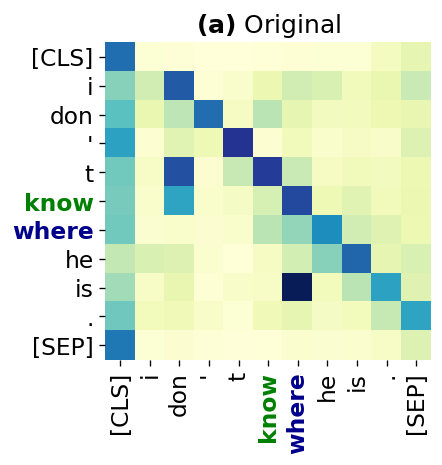

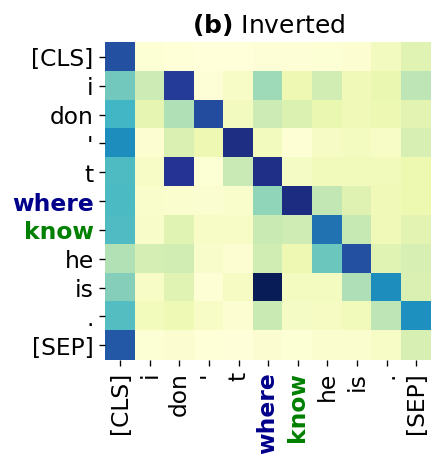

['i', 'don', "'", 't', 'where', 'know', 'he', 'is', '.']


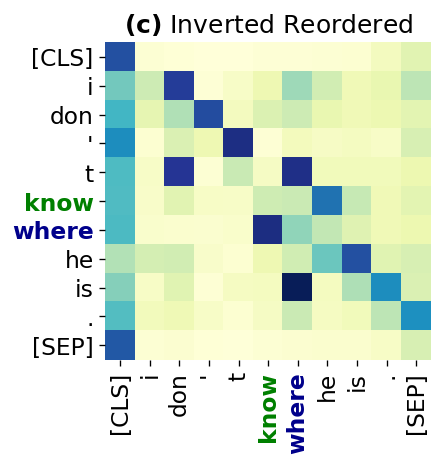

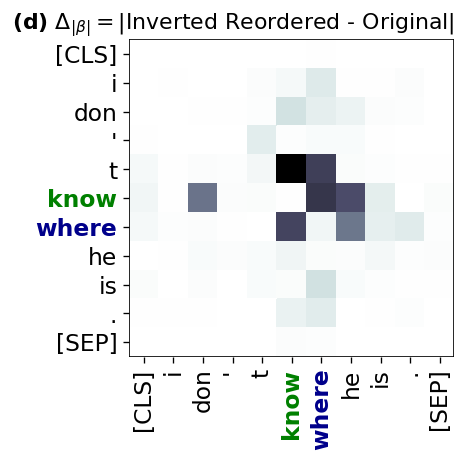

In [ ]:
# @title Sigma Alpha Norm
layer =  2#@param {type:"integer"}
ex =  517#@param {type:"integer"}

plt.rcParams['figure.dpi'] = 120

A = summed_afx_norms[layer][ex]
D = inverted_summed_afx_norms[layer][ex]
B = align_attn_heatmap(D, first_position[ex], second_position[ex])

tokens = tokenizer.tokenize(original_data[ex])
ticks = len(tokens) + 2
print(tokens)
print(first_position[ex], second_position[ex])
A = A[:np.sum(att_masks[ex]), :np.sum(att_masks[ex])]

plt.figure(figsize=(3.5,3.5))
plt.title(r"$\bf{(a)}$" + " Original", size=15)
ax = sns.heatmap(A, cmap="YlGnBu", cbar=False)
plt.xticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=90, size=14)
plt.yticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=0, size=14)
ax.get_xticklabels()[5].set_color("green")
ax.get_xticklabels()[6].set_color("darkblue")
ax.get_xticklabels()[5].set_fontweight("bold")
ax.get_xticklabels()[6].set_fontweight("bold")

ax.get_yticklabels()[5].set_color("green")
ax.get_yticklabels()[6].set_color("darkblue")
ax.get_yticklabels()[5].set_fontweight("bold")
ax.get_yticklabels()[6].set_fontweight("bold")
plt.show()

inv_tokens = tokenizer.tokenize(inverted_data[ex])
D = D[:np.sum(att_masks[ex]), :np.sum(att_masks[ex])]

plt.figure(figsize=(3.5,3.5))
plt.title(r"$\bf{(b)}$" + " Inverted", size=15)
ax = sns.heatmap(D, cmap="YlGnBu", cbar=False)
plt.xticks(np.arange(ticks)+0.5, ['[CLS]'] + inv_tokens + ['[SEP]'], rotation=90, size=14)
plt.yticks(np.arange(ticks)+0.5, ['[CLS]'] + inv_tokens + ['[SEP]'], rotation=0, size=14)
ax.get_xticklabels()[6].set_color("green")
ax.get_xticklabels()[5].set_color("darkblue")
ax.get_xticklabels()[6].set_fontweight("bold")
ax.get_xticklabels()[5].set_fontweight("bold")

ax.get_yticklabels()[6].set_color("green")
ax.get_yticklabels()[5].set_color("darkblue")
ax.get_yticklabels()[6].set_fontweight("bold")
ax.get_yticklabels()[5].set_fontweight("bold")
plt.show()

print(tokenizer.tokenize(inverted_data[ex]))
B = B[:np.sum(att_masks[ex]), :np.sum(att_masks[ex])]
plt.figure(figsize=(3.5,3.5))
plt.title(r"$\bf{(c)}$" + " Inverted Reordered", size=15)
ax = sns.heatmap(B, cmap="YlGnBu", cbar=False)
plt.xticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=90, size=14)
plt.yticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=0, size=14)
ax.get_xticklabels()[5].set_color("green")
ax.get_xticklabels()[6].set_color("darkblue")
ax.get_xticklabels()[5].set_fontweight("bold")
ax.get_xticklabels()[6].set_fontweight("bold")

ax.get_yticklabels()[5].set_color("green")
ax.get_yticklabels()[6].set_color("darkblue")
ax.get_yticklabels()[5].set_fontweight("bold")
ax.get_yticklabels()[6].set_fontweight("bold")
plt.show()

plt.figure(figsize=(3.5,3.5))
plt.title(r"$\bf{(d)}$ $\Delta_{|\beta|}" + ' = $|Inverted Reordered - Original|', size=13.2, loc='right')
ax = sns.heatmap(np.abs(B - A), cbar=False, cmap='bone_r')
plt.xticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=90, size=14)
plt.yticks(np.arange(ticks)+0.5, ['[CLS]'] + tokens + ['[SEP]'], rotation=0, size=14)
ax.get_xticklabels()[5].set_color("green")
ax.get_xticklabels()[6].set_color("darkblue")
ax.get_xticklabels()[5].set_fontweight("bold")
ax.get_xticklabels()[6].set_fontweight("bold")

ax.get_yticklabels()[5].set_color("green")
ax.get_yticklabels()[6].set_color("darkblue")
ax.get_yticklabels()[5].set_fontweight("bold")
ax.get_yticklabels()[6].set_fontweight("bold")

ax.axhline(y=0, color='k',linewidth=1)
ax.axhline(y=11, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
ax.axvline(x=11, color='k',linewidth=1)
plt.show()

In [ ]:
attentions_merged_realigned = np.zeros((12, no_examples, 2*MAX_LENGTH, 2*MAX_LENGTH))

In [ ]:
for ex in tqdm(range(no_examples)):
  for layer in range(12):
    A = summed_afx_norms[layer][ex]
    B = inverted_summed_afx_norms[layer][ex]
    B = align_attn_heatmap(B, first_position[ex], second_position[ex])

    delta = np.abs(B - A)
    bigram = first_position[ex] + second_position[ex]
    bigram_start = min(bigram)
    bigram_end = max(bigram) + 1
    sen_len = np.sum(att_masks[ex])
    mask_size = sen_len**2
    bigram_size = len(bigram)**2

    attentions_merged_realigned[layer, ex][MAX_LENGTH - bigram_start:MAX_LENGTH - bigram_start + sen_len, MAX_LENGTH - bigram_start:MAX_LENGTH - bigram_start + sen_len] = delta[:sen_len, :sen_len].copy()

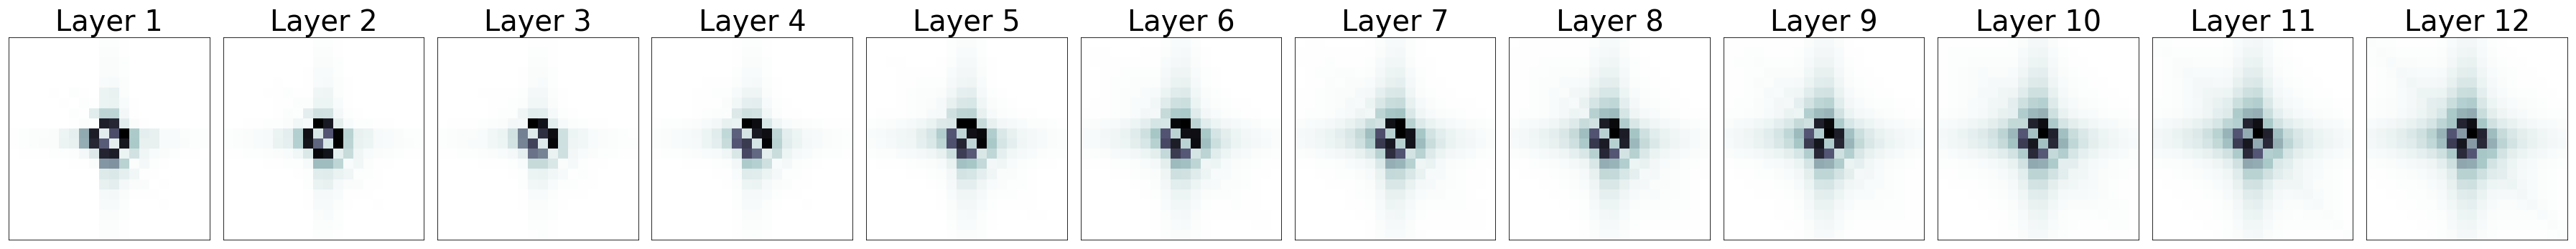

In [ ]:
side_crop = 37
fig = plt.figure(figsize = (30,3))
# max = np.max(np.sum(np.mean(attentions_merged_realigned, axis=1)[:11+1, 2+side_crop:-side_crop, 2+side_crop:-side_crop], axis=0)
layers = np.arange(12)
for idx, i in enumerate(layers):
  ax = fig.add_subplot(1, len(layers), idx+1)
  ax.set_title("Layer " + str(i+1), size=24)
  ax = sns.heatmap(np.sum(np.mean(attentions_merged_realigned, axis=1)[:i+1, 2+side_crop:-side_crop, 2+side_crop:-side_crop], axis=0), ax=ax, cbar=False, cmap='bone_r')
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=20, color='k',linewidth=1)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=20, color='k',linewidth=1)
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

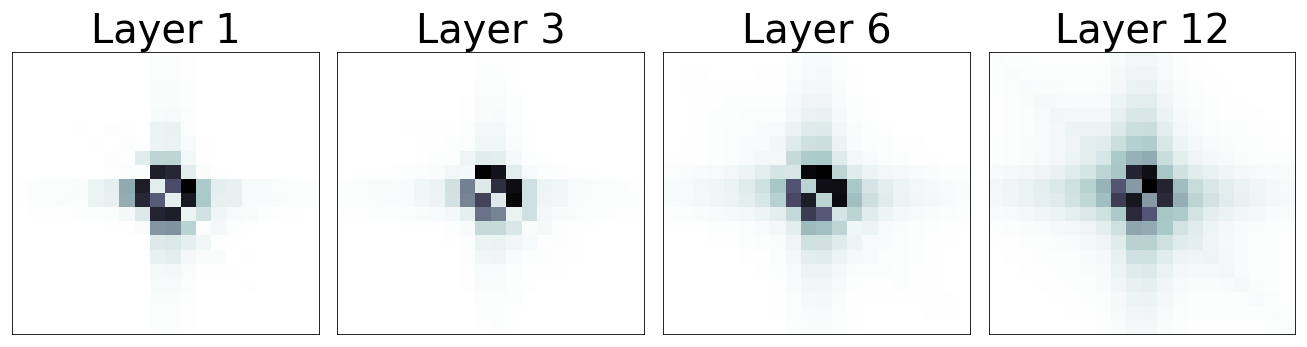

In [ ]:
side_crop = 37
fig = plt.figure(figsize = (11,3))
# max = np.max(np.sum(np.mean(attentions_merged_realigned, axis=1)[:11+1, 2+side_crop:-side_crop, 2+side_crop:-side_crop], axis=0)
layers = [0, 2, 5, 11]
for idx, i in enumerate(layers):
  ax = fig.add_subplot(1, len(layers), idx+1)
  ax.set_title("Layer " + str(i+1), size=24)
  ax = sns.heatmap(np.sum(np.mean(attentions_merged_realigned, axis=1)[:i+1, 2+side_crop:-side_crop, 2+side_crop:-side_crop], axis=0), ax=ax, cbar=False, cmap='bone_r')
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=20, color='k',linewidth=1)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=20, color='k',linewidth=1)
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()